In [1]:
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt
from math import floor

In [2]:
import ipywidgets as widgets
from IPython.display import display

# Modulate

## Set up constants for 2 FSK signal

In [3]:
# Output sample rate in samples per second
fs = 200000

# Output symbol rate
fb = 20000

# Set deviation for each symbol in Hz
f0 = 80000
f1 = -80000

# AM Modulation
am_amp = 0
am_freq = 10000

# Set the signal to noise ratio of the signal in db
snr = 15

# Number of symbols to send in each message 
symbols_per_msg = 1000

## Generate random symbols

In [4]:
# Use a fixed random seed for a repeatable output
np.random.seed(934839)
symbols = np.random.randint(2, size=symbols_per_msg)
#symbols = np.array([0,1] * 500)

## Generate complex baseband signal

In [5]:
phase_accum = 0.0
symbol_accum = 0.0
symbol = 0

# Since the symbol rate might not be a integer multiple of the sample rate
# we use an accumulator to on average output symbols at the right rate
symbol_rate_step = (fb * 2**32) / fs

# Replace symbols with their step deviation (step deviation = (f * 2**32)/fs)
deviation = symbols.copy()
np.place(deviation, symbols == 0, int((f0 * 2**32) / fs))
np.place(deviation, symbols == 1, int((f1 * 2**32) / fs))

wave = []

while True:
    
    # First inc the sample rate accumulator
    symbol_accum = symbol_accum + symbol_rate_step
    
    # If accumulator overflows we are ready for the next symbol
    if (symbol_accum >= 2.0**32):
        symbol_accum = symbol_accum - 2.0**32
        symbol += 1
        # Check if we have reached the end of the message
        if symbol == symbols_per_msg:
            break
    
    # Output the sample
    wave.append(np.exp(2.0j * np.pi * phase_accum/float(2**32)))
    
    # Increament the phase accumulator based on the current symbol
    phase_accum = phase_accum + deviation[symbol]

    if (phase_accum >= 2.0**32):
        phase_accum = phase_accum - 2.0**32
    elif (phase_accum < 0.0):
        phase_accum = 2.0**32 + phase_accum

## Add AM modulation

In [6]:
# Add AM modulation
n = np.arange(0,len(wave))
am_mod = (am_amp * np.cos(2.0*np.pi*am_freq*n/fs))
wave = wave * (1+am_mod)

## Add noise

In [7]:
def addNoise(signal, desiredSNR_db):
    
    length = len(signal)
    # Generate some noise
    noise = np.random.random_sample(length) - 0.5
    noise2 = np.random.random_sample(length) - 0.5
    # Apply noise to both I and Q
    noise = noise + (1j * noise2)
    
    # Calculate the power in the signal and the generated noise
    sig_power = sum(np.power(np.abs(signal),2))/length
    noise_power = sum(np.power(np.abs(noise),2))/length
    
    #Scale to noise to achieve the desired SNR
    scaled_noise = noise * np.sqrt( sig_power/noise_power * 10.0**(-desiredSNR_db / 10.0))
    # Check the SNR ratio
    #scaled_noise_power = sum(np.power(np.abs(scaled_noise),2))/length
    #print(10*np.log10(sig_power/scaled_noise_power))
    
    return (signal + scaled_noise)
    
noisy_wave = addNoise(wave, snr)

## Plot IQ data

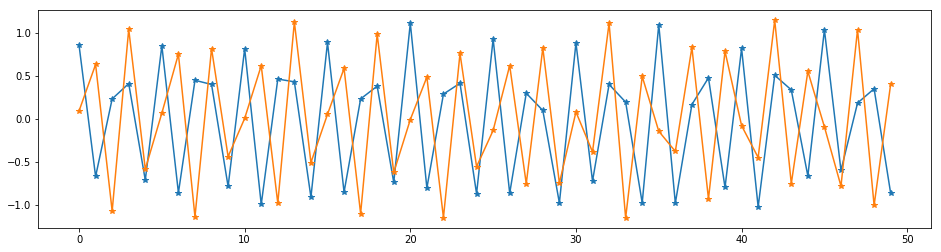

In [8]:
iq_plot_length = 50
plt.figure(figsize=(16,4))
plt.plot(np.real(noisy_wave[0:iq_plot_length]), '-*')
plt.plot(np.imag(noisy_wave[0:iq_plot_length]), '-*')
if am_amp > 0:
    plt.plot(am_mod[0:iq_plot_length], '-*')
plt.show()

## Plot FFT of signal

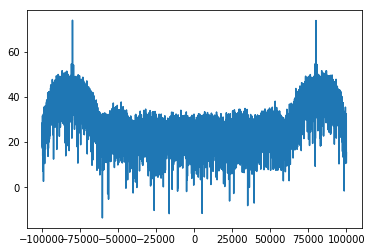

In [9]:
freqs = np.linspace(-fs/2,+fs/2, len(noisy_wave))
plt.plot(freqs,20*np.log10(np.fft.fftshift(np.abs(np.fft.fft(noisy_wave)))))
plt.show()

# Demodulate

## Plot Frequency Deviation of signal
This is a basic way of demodulating FSK signals with a high SNR

In [10]:
phase_dev = noisy_wave[1:] * np.conjugate(noisy_wave[0:-1])
freq_dev = np.arctan2(np.imag(phase_dev), np.real(phase_dev))
amp_dev = np.abs(phase_dev)

quantised_diff1 = freq_dev.copy()
np.place(quantised_diff1, quantised_diff1 >= 0, 2)
np.place(quantised_diff1, quantised_diff1 < 0, -2)

def plotFreqDeviation(start, length):
    plt.figure(figsize=(16,4))
    plt.plot(freq_dev[start:start+length], '-*')
    plt.plot(quantised_diff1[start:start+length], '-*')
    
    #plt.plot(am_mod[start:start+length], '-*')
    plt.plot(amp_dev[start:start+length], '-*')
    plt.show()

freq_dev_start_point = widgets.BoundedIntText(0,min=0, max=len(freq_dev), description='Start: ')
freq_dev_plot_length = widgets.BoundedIntText(200,min=0, max=len(freq_dev), description='Length: ')

widgets.interactive(plotFreqDeviation, start=freq_dev_start_point, length=freq_dev_plot_length)

interactive(children=(BoundedIntText(value=0, description='Start: ', max=9999), BoundedIntText(value=200, description='Length: ', max=9999), Output()), _dom_classes=('widget-interact',))

## Generate Matched Filters for each symbol

In [11]:
def getMatchedFilter(symbol_freq, symbol_rate, sample_rate):
    matched_filter = []
    phase_accum = 0.0    
    step = (symbol_freq * 2**32) / sample_rate    
    matched_filter_length = int(floor(sample_rate/symbol_rate))
    
    for _ in range(0,matched_filter_length):    
   
        # Output the sample
        matched_filter.append(np.exp(2.0j * np.pi * phase_accum/float(2**32)))

        # Increament the phase accumulator
        phase_accum = phase_accum + step

        if (phase_accum >= 2.0**32):
            phase_accum = phase_accum - 2.0**32
        elif (phase_accum < 0.0):
            phase_accum = 2.0**32 + phase_accum
            
            
    return matched_filter

filter0 = getMatchedFilter(f0,fb,fs)
filter1 = getMatchedFilter(f1,fb,fs)

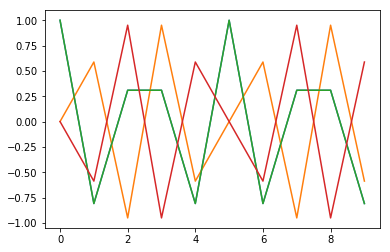

In [12]:
plt.plot(np.real(filter0))
plt.plot(np.imag(filter0))
plt.plot(np.real(filter1))
plt.plot(np.imag(filter1))
plt.show()

## Apply matched filters to signal

In [13]:
filter_symbol0 = signal.lfilter(filter0,1,noisy_wave)
filter_symbol1 = signal.lfilter(filter1,1,noisy_wave)

# Calculate the difference between the two filters
diff = np.abs(filter_symbol0) - np.abs(filter_symbol1)

# Quantise the signal to a 0 or 1 (shown at +4 or -4 to look better on the graph)
quantised_diff = diff.copy()
np.place(quantised_diff, quantised_diff >= 0, 4)
np.place(quantised_diff, quantised_diff < 0, -4)

## Plot output of matched filter detector

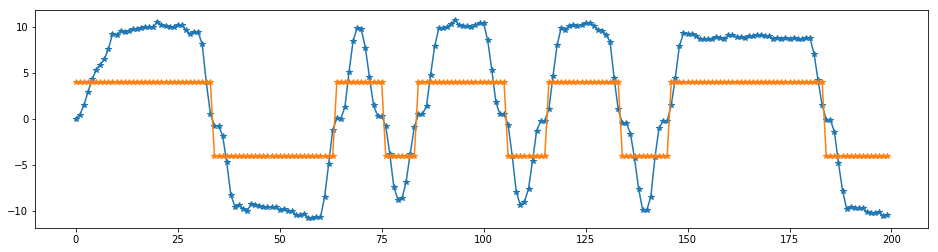

[0 0 0 1 1 1 0 1 0 0 1 0 0 1 0]


In [14]:
plt.figure(figsize=(16,4))
plt.plot(diff[0:200], '-*')
plt.plot(quantised_diff[0:200], '-*')
plt.show()
print(symbols[0:15])